# Capstone Project - Pneumonia Detection using Deep Learning

In [ ]:
# Step 1: Import Libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
import cv2
from tqdm import tqdm

In [ ]:
# Step 2: Load the CSV Files

train_labels = pd.read_csv('stage_2_train_labels.csv')
class_info = pd.read_csv('stage_2_detailed_class_info.csv')

print("Train Labels Sample:")
print(train_labels.head())
print("\nClass Info Sample:")
print(class_info.head())

Train Labels Sample:
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

Class Info Sample:
                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity


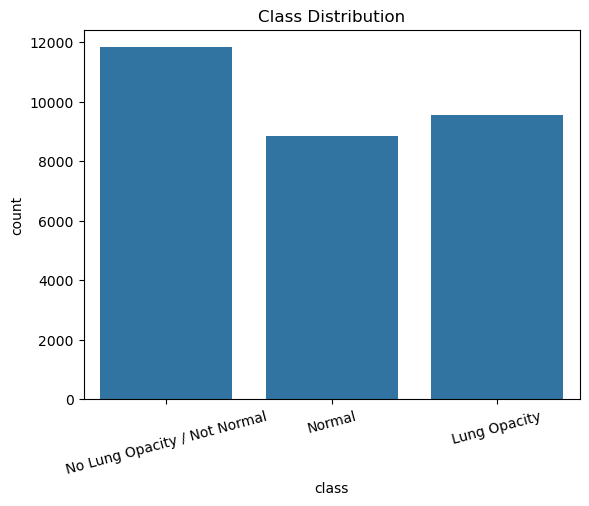

In [ ]:
# Step 3: EDA - Class Distribution

sns.countplot(data=class_info, x='class')
plt.title("Class Distribution")
plt.xticks(rotation=15)
plt.show()

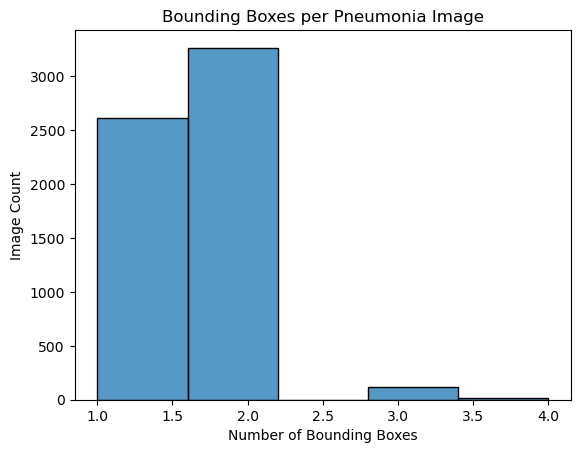

In [ ]:
# Step 4: EDA - Bounding Boxes per Image (only where Target == 1)

pneumonia_boxes = train_labels[train_labels['Target'] == 1].groupby('patientId').size()
sns.histplot(pneumonia_boxes, bins=5)
plt.title("Bounding Boxes per Pneumonia Image")
plt.xlabel("Number of Bounding Boxes")
plt.ylabel("Image Count")
plt.show()

In [ ]:
# Step 5: Check for Missing Values
print("\nMissing values in training labels:")
print(train_labels.isnull().sum())


Missing values in training labels:
patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
dtype: int64


In [ ]:
import zipfile
import os
import shutil

# General function to extract ZIPs and flatten if needed
def extract_zip(zip_filename, extract_dir):
    if not os.path.exists(extract_dir):
        print(f"🔄 Extracting {zip_filename}...")
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

        # Check for nested same-named folder (common issue)
        nested = os.path.join(extract_dir, os.path.basename(extract_dir))
        if os.path.isdir(nested):
            # Move all files up one level
            for filename in os.listdir(nested):
                shutil.move(os.path.join(nested, filename), extract_dir)
            os.rmdir(nested)
            print(f"📂 Flattened nested folder in {extract_dir}")
        print(f"✅ Extracted to: {extract_dir}")
    else:
        print(f"✅ Folder already exists: {extract_dir}")

# Extract train and test
extract_zip("stage_2_train_images.zip", "stage_2_train_images")
extract_zip("stage_2_test_images.zip", "stage_2_test_images")

🔄 Extracting stage_2_train_images.zip...
📂 Flattened nested folder in stage_2_train_images
✅ Extracted to: stage_2_train_images
🔄 Extracting stage_2_test_images.zip...
📂 Flattened nested folder in stage_2_test_images
✅ Extracted to: stage_2_test_images


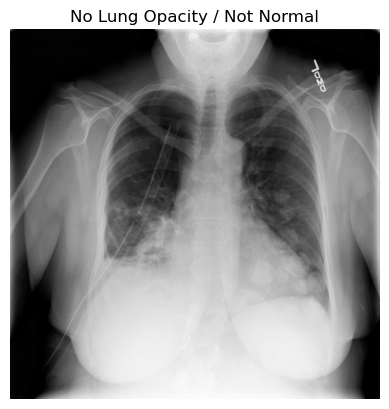

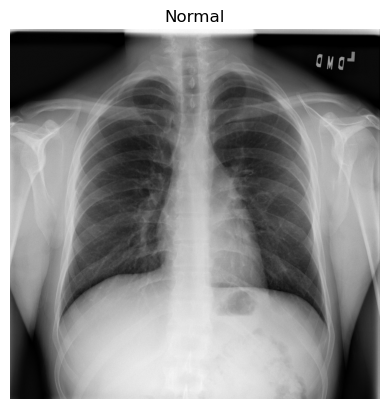

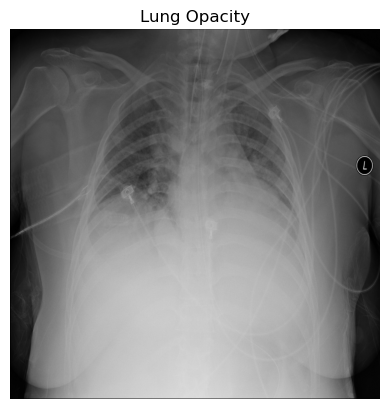

In [ ]:
# Step 6: DICOM Visualization Function
img_dir = 'stage_2_train_images'  # ✅ updated to point to correct extracted folder

def show_dicom_image(patient_id, label=None):
    path = os.path.join(img_dir, patient_id + ".dcm")
    if os.path.exists(path):
        dcm = pydicom.dcmread(path)
        plt.imshow(dcm.pixel_array, cmap='gray')
        plt.axis('off')
        if label:
            plt.title(label)
        plt.show()
    else:
        print(f"❌ File not found: {path}")

# Show one image per class
available_ids = set(os.listdir(img_dir))
for class_name in class_info['class'].unique():
    sample = class_info[class_info['class'] == class_name].iloc[0]['patientId']
    if f"{sample}.dcm" in available_ids:
        show_dicom_image(sample, class_name)


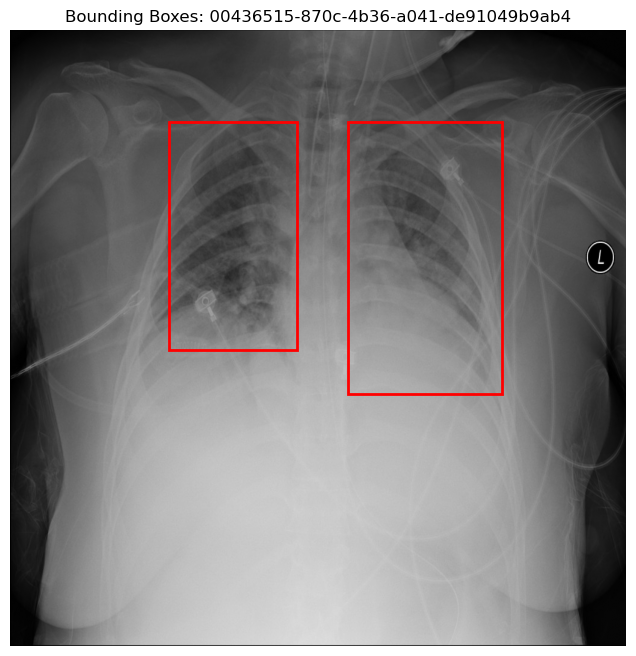

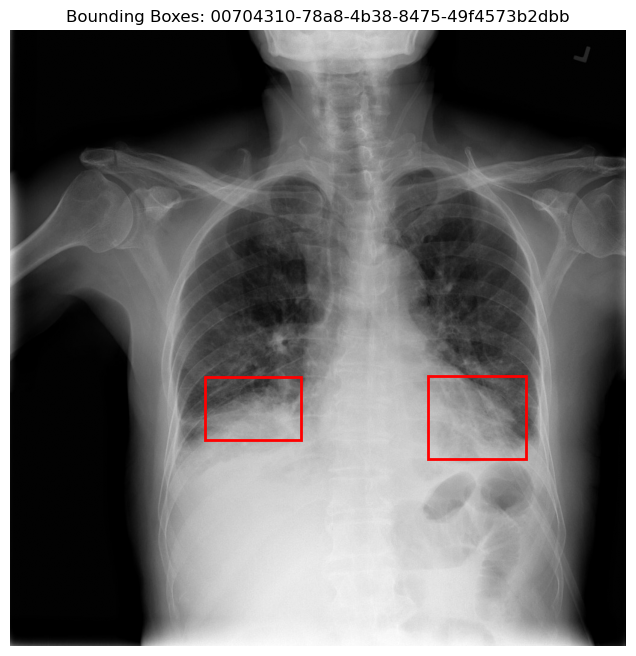

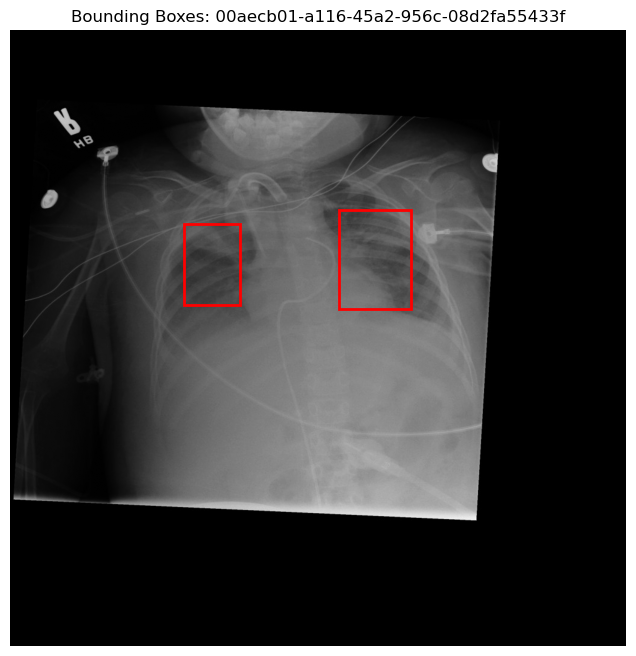

In [ ]:
# Step 7: Display Images with Bounding Boxes
import matplotlib.patches as patches

def show_dicom_with_boxes(patient_id, boxes):
    dcm_path = os.path.join(img_dir, patient_id + ".dcm")
    if not os.path.exists(dcm_path):
        print(f"❌ File not found: {dcm_path}")
        return
    dcm = pydicom.dcmread(dcm_path)
    image = dcm.pixel_array
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(image, cmap='gray')
    for box in boxes:
        x, y, w, h = box
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
    ax.set_title(f"Bounding Boxes: {patient_id}")
    ax.axis('off')
    plt.show()

# Display for a few pneumonia images
pneumonia_df = train_labels[train_labels['Target'] == 1]
sample_ids = pneumonia_df['patientId'].unique()[:3]

for pid in sample_ids:
    boxes = pneumonia_df[pneumonia_df['patientId'] == pid][['x', 'y', 'width', 'height']].values.tolist()
    show_dicom_with_boxes(pid, boxes)

In [ ]:
# Step 8: Summary
print("""
Summary:
- Loaded and explored DICOM image data with labels
- Performed EDA including class distribution and bounding box analysis
- Visualized representative samples from each class
- Overlaid bounding boxes on pneumonia cases
- Dataset is now ready for modeling phase
""")


Summary:
- Loaded and explored DICOM image data with labels
- Performed EDA including class distribution and bounding box analysis
- Visualized representative samples from each class
- Overlaid bounding boxes on pneumonia cases
- Dataset is now ready for modeling phase



In [ ]:
import zipfile

zip_path = 'stage_2_train_images.zip'  # Make sure the filename is correct
extract_path = 'stage_2_train_images'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")

Extraction complete!


In [ ]:
# Step 3: EDA - Class Distribution

import pandas as pd

# Load class info
class_info = pd.read_csv('stage_2_detailed_class_info.csv')

# Preview the data
print(" Class Info Preview:")
display(class_info.head())

# Count how many images are in each class
class_counts = class_info['class'].value_counts()
print("\n Class Distribution:")
print(class_counts)

 Class Info Preview:


,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity



 Class Distribution:
class
No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: count, dtype: int64


In [ ]:
import pandas as pd

# Load the training labels CSV (bounding box + class info)
train_labels = pd.read_csv('stage_2_train_labels.csv')
class_info = pd.read_csv('stage_2_detailed_class_info.csv')


In [ ]:
# Filter only rows with pneumonia
pneumonia_df = train_labels[train_labels['Target'] == 1]

print(" Pneumonia image count:", pneumonia_df['patientId'].nunique())

# Group boxes for each image
grouped_boxes = pneumonia_df.groupby('patientId')[['x', 'y', 'width', 'height']].apply(lambda x: x.values.tolist())
grouped_boxes = grouped_boxes.reset_index().rename(columns={0: 'boxes'})

# Preview few rows
grouped_boxes.head()

 Pneumonia image count: 6012


,patientId,boxes
0,000db696-cf54-4385-b10b-6b16fbb3f985,"[[316.0, 318.0, 170.0, 478.0], [660.0, 375.0, ..."
1,000fe35a-2649-43d4-b027-e67796d412e0,"[[570.0, 282.0, 269.0, 409.0], [83.0, 227.0, 2..."
2,001031d9-f904-4a23-b3e5-2c088acd19c6,"[[66.0, 160.0, 373.0, 608.0], [552.0, 164.0, 3..."
3,001916b8-3d30-4935-a5d1-8eaddb1646cd,"[[198.0, 375.0, 114.0, 206.0]]"
4,0022073f-cec8-42ec-ab5f-bc2314649235,"[[575.0, 232.0, 246.0, 528.0], [161.0, 230.0, ..."


In [ ]:
import zipfile

zip_path = 'stage_2_train_images.zip'
extract_path = 'stage_2_train_images'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Re-extraction complete!")

✅ Re-extraction complete!


In [ ]:
dcm_files = [f for f in os.listdir(extract_path) if f.endswith('.dcm')]
print(f"✅ Total DICOM files found after fix: {len(dcm_files)}")

✅ Total DICOM files found after fix: 26684


🖼️ Showing: No Lung Opacity / Not Normal


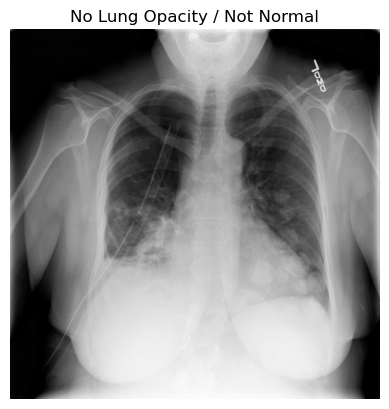

🖼️ Showing: Normal


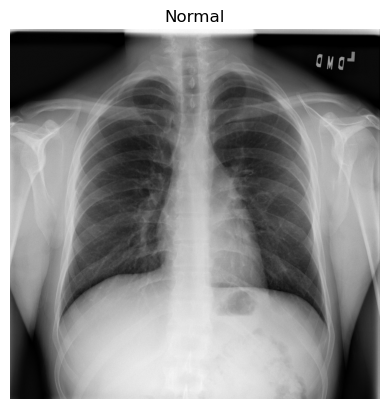

🖼️ Showing: Lung Opacity


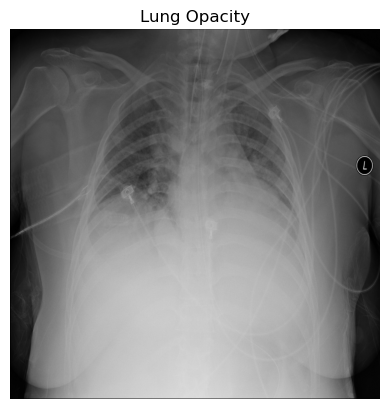

In [ ]:
import pydicom
import matplotlib.pyplot as plt
import os

img_dir = 'stage_2_train_images'

# Get available file names (without extension)
available_files = set([f.replace('.dcm', '') for f in os.listdir(img_dir) if f.endswith('.dcm')])

# Function to show image
def show_dicom_image(patient_id, label=None):
    dcm_path = os.path.join(img_dir, patient_id + ".dcm")
    if not os.path.exists(dcm_path):
        print(f"❌ File not found: {dcm_path}")
        return
    dcm = pydicom.dcmread(dcm_path)
    plt.imshow(dcm.pixel_array, cmap='gray')
    plt.axis('off')
    if label:
        plt.title(label)
    plt.show()

# Display one sample from each class
for class_name in class_info['class'].unique():
    subset = class_info[class_info['class'] == class_name]
    valid_sample = next((pid for pid in subset['patientId'].values if pid in available_files), None)

    if valid_sample:
        print(f"🖼️ Showing: {class_name}")
        show_dicom_image(valid_sample, class_name)
    else:
        print(f"⚠️ No valid image found for: {class_name}")

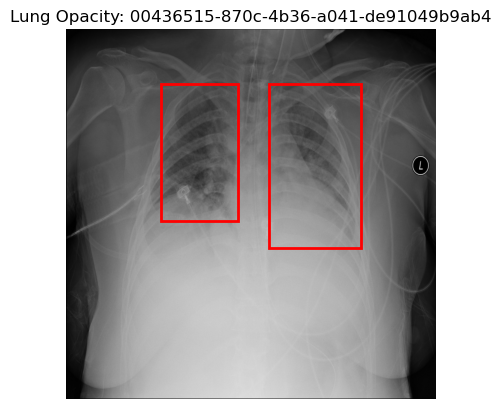

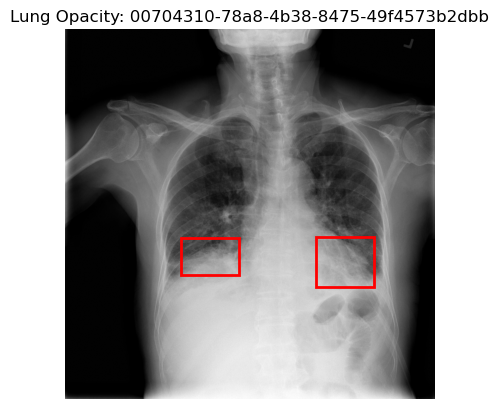

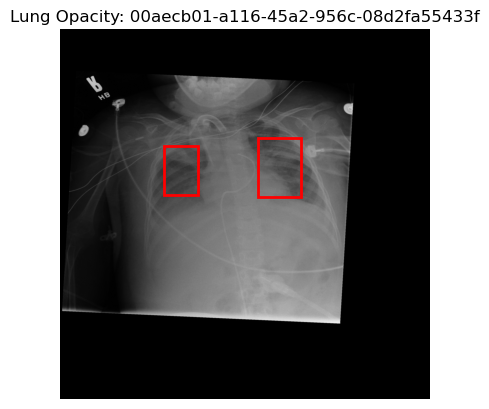

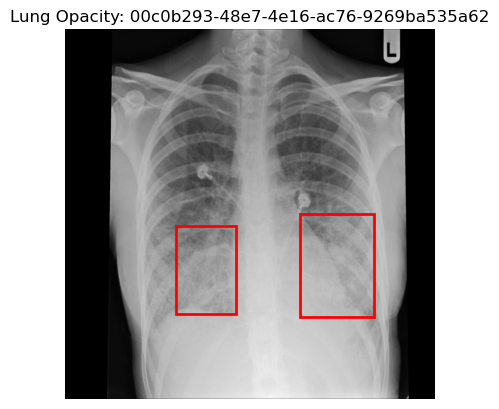

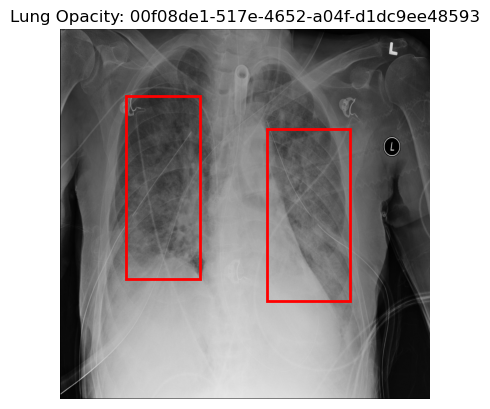

In [ ]:
import matplotlib.patches as patches

# Filter only pneumonia cases (Target = 1)
pneumonia_cases = train_labels[train_labels['Target'] == 1]
pneumonia_cases = pneumonia_cases[pneumonia_cases['patientId'].isin(available_files)]

# Pick a few patientIds with bounding boxes
sample_ids = pneumonia_cases['patientId'].unique()[:5]

for patient_id in sample_ids:
    dcm_path = os.path.join(img_dir, patient_id + ".dcm")
    if not os.path.exists(dcm_path):
        continue
    dcm = pydicom.dcmread(dcm_path)
    image = dcm.pixel_array

    # Get bounding boxes for this image
    boxes = pneumonia_cases[pneumonia_cases['patientId'] == patient_id][['x', 'y', 'width', 'height']].values

    # Plot image
    fig, ax = plt.subplots(1)
    ax.imshow(image, cmap='gray')
    for box in boxes:
        x, y, w, h = box
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
    ax.set_title(f"Lung Opacity: {patient_id}")
    plt.axis('off')
    plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import os

# Filter only available files
class_df = class_info[class_info['patientId'].isin(available_files)].copy()
class_df['filepath'] = class_df['patientId'].apply(lambda x: os.path.join(img_dir, x + '.dcm'))

# Encode class labels
label_encoder = LabelEncoder()
class_df['label'] = label_encoder.fit_transform(class_df['class'])

print("✅ Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
class_df.head()

✅ Label mapping: {'Lung Opacity': 0, 'No Lung Opacity / Not Normal': 1, 'Normal': 2}


,patientId,class,filepath,label
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,stage_2_train_images/0004cfab-14fd-4e49-80ba-6...,1
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c...,1
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,stage_2_train_images/00322d4d-1c29-4943-afc9-b...,1
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,stage_2_train_images/003d8fa0-6bf1-40ed-b54c-a...,2
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,stage_2_train_images/00436515-870c-4b36-a041-d...,0


In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2

IMG_SIZE = 224

def load_dicom_image(path):
    dcm = pydicom.dcmread(path)
    img = dcm.pixel_array
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype(np.float32) / 255.0  # normalize
    return img

# Load a small sample to test (for quick training)
sample_df = class_df.sample(2000, random_state=42)  # use full later if GPU handles well

# Load images
X = np.array([load_dicom_image(path) for path in sample_df['filepath']])
X = np.expand_dims(X, axis=-1)  # Add channel dimension

y = to_categorical(sample_df['label'])

# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=sample_df['label'], test_size=0.2, random_state=42)

2025-06-19 13:26:12.327014: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-19 13:26:12.365719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-19 13:26:12.376452: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-19 13:26:12.379504: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-19 13:26:12.418953: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/home/krishnag/miniconda3/envs/GLproject/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1750319779.849114   10269 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750319779.954106   10269 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750319779.95

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,203 (91.20 MB)

 Trainable params: 23,907,203 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

Epoch 1/5


I0000 00:00:1750319783.930618   13329 service.cc:146] XLA service 0x701764003bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750319783.930637   13329 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2025-06-19 13:26:23.953593: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-19 13:26:24.027125: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


11/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3485 - loss: 3.6947

I0000 00:00:1750319785.878337   13329 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.3967 - loss: 2.2097 - val_accuracy: 0.5525 - val_loss: 0.9390
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5507 - loss: 0.9205 - val_accuracy: 0.5550 - val_loss: 0.9257
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5995 - loss: 0.8463 - val_accuracy: 0.5825 - val_loss: 0.9480
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6484 - loss: 0.7584 - val_accuracy: 0.5675 - val_loss: 0.9328
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7409 - loss: 0.6108 - val_accuracy: 0.5550 - val_loss: 0.9988


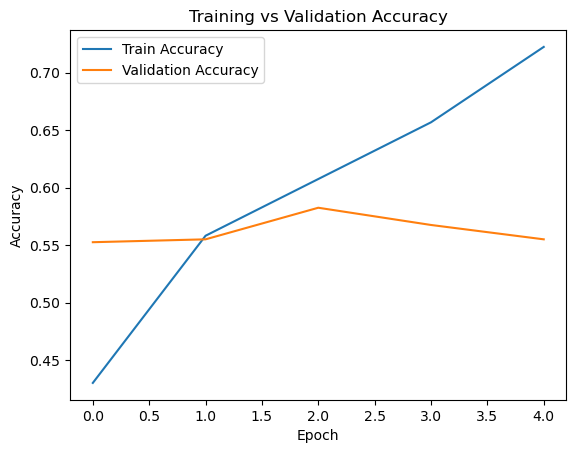

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

In [ ]:
# Variant CNN with 3 Conv blocks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

variant_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')  # 3 output classes
])

variant_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
variant_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,244,867 (84.86 MB)

 Trainable params: 22,244,867 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
variant_history = variant_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.3509 - loss: 1.4575 - val_accuracy: 0.4200 - val_loss: 1.0602
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4716 - loss: 1.0098 - val_accuracy: 0.5350 - val_loss: 0.9569
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5340 - loss: 0.9437 - val_accuracy: 0.5750 - val_loss: 0.8973
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5768 - loss: 0.8724 - val_accuracy: 0.5650 - val_loss: 0.8922
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6098 - loss: 0.8246 - val_accuracy: 0.5500 - val_loss: 0.8885


/home/krishnag/miniconda3/envs/GLproject/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


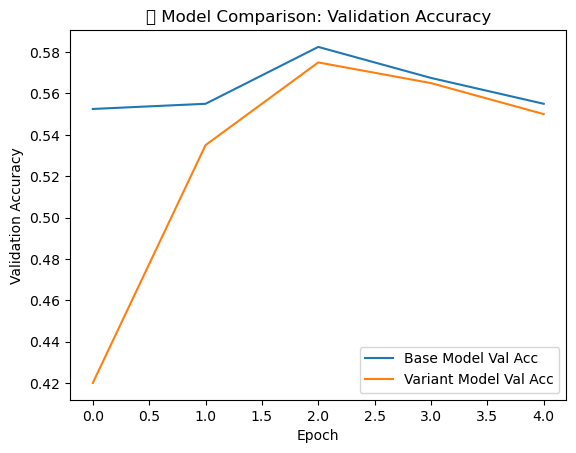

In [ ]:
plt.plot(history.history['val_accuracy'], label='Base Model Val Acc')
plt.plot(variant_history.history['val_accuracy'], label='Variant Model Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('📊 Model Comparison: Validation Accuracy')
plt.show()

In [ ]:
#Step 1: Fine tune the trained basic CNN models for classification.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import numpy as np
import cv2
import pandas as pd

# Step 1: Fine-tune the trained basic CNN model for classification

# Load the label data
train_labels = pd.read_csv("stage_2_train_labels.csv")
class_info = pd.read_csv("stage_2_detailed_class_info.csv")

# Merge to get class labels
train_df = pd.merge(train_labels, class_info, on="patientId")

# Balance the dataset for training quickly
sample_df = train_df.groupby("class").apply(lambda x: x.sample(n=200, random_state=42)).reset_index(drop=True)

# Load and resize DICOM images
IMG_SIZE = 128
image_dir = "stage_2_train_images/stage_2_train_images"
X = []
y = []

for index, row in sample_df.iterrows():
    patient_id = row['patientId']
    label = 1 if row['class'] == "Lung Opacity" else 0
    file_path = os.path.join(image_dir, f"{patient_id}.dcm")
    if os.path.exists(file_path):
        try:
            import pydicom
            dcm = pydicom.dcmread(file_path)
            img = dcm.pixel_array
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0
            X.append(img)
            y.append(label)
        except Exception as e:
            continue

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model architecture
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D((2,2)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

# Evaluate
val_loss, val_acc = model.evaluate(X_val, y_val)
val_acc


/tmp/ipykernel_10269/1019792086.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = train_df.groupby("class").apply(lambda x: x.sample(n=200, random_state=42)).reset_index(drop=True)


Epoch 1/5


/home/krishnag/miniconda3/envs/GLproject/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5888 - loss: 7.5109 - val_accuracy: 0.3583 - val_loss: 0.8092
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7636 - loss: 0.8517 - val_accuracy: 0.4333 - val_loss: 0.6926
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6855 - loss: 1.0021 - val_accuracy: 0.3750 - val_loss: 0.7221
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7563 - loss: 0.4741 - val_accuracy: 0.3583 - val_loss: 0.7157
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7797 - loss: 0.5272 - val_accuracy: 0.5583 - val_loss: 0.6906
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5556 - loss: 0.6883 


0.5583333373069763

In [ ]:
# Step 2: Apply Transfer Learning model for classification?

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os

# Load training labels
train_df = pd.read_csv("stage_2_train_labels.csv")

# Balance the dataset: sample equal instances for both classes
balanced_df = train_df.groupby("Target").apply(lambda x: x.sample(n=500, random_state=42)).reset_index(drop=True)

# Prepare image directory and DICOM to image conversion
import pydicom
import cv2

def load_dicom_image(patient_id, size=(224, 224)):
    dcm_path = os.path.join("stage_2_train_images", f"{patient_id}.dcm")
    if not os.path.exists(dcm_path):
        return None
    dcm = pydicom.dcmread(dcm_path)
    img = dcm.pixel_array
    img = cv2.resize(img, size)
    img = np.stack((img,)*3, axis=-1)  # convert grayscale to RGB
    img = img / 255.0  # normalize
    return img

# Load image data
X = []
y = []

for idx, row in balanced_df.iterrows():
    img = load_dicom_image(row['patientId'])
    if img is not None:
        X.append(img)
        y.append(row['Target'])

X = np.array(X)
y = np.array(y)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Load VGG16 base model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model_tl = Model(inputs=base_model.input, outputs=output)

# Compile
model_tl.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_tl = model_tl.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

# Evaluate
val_loss_tl, val_acc_tl = model_tl.evaluate(X_val, y_val)
val_acc_tl

/tmp/ipykernel_10269/3500576974.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = train_df.groupby("Target").apply(lambda x: x.sample(n=500, random_state=42)).reset_index(drop=True)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step 
Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.5669 - loss: 1.4083 - val_accuracy: 0.6800 - val_loss: 0.6034
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7353 - loss: 0.5670 - val_accuracy: 0.6750 - val_loss: 0.6495
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7702 - loss: 0.5191 - val_accuracy: 0.6900 - val_loss: 0.5738
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7862 - loss: 0.4477 - val_accuracy: 0.6950 - val_loss: 0.6155
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8055 - loss: 0.4074 - val_accuracy: 0.6850 - val_loss: 0.5901
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7134 - loss: 0.5704


0.6850000023841858

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


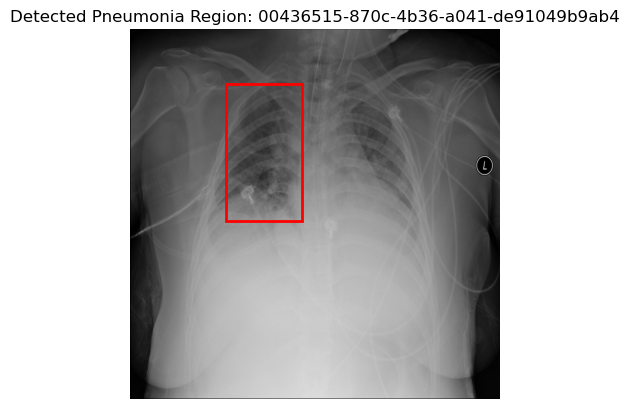

In [ ]:
# Step 3: R-CNN Based Object Detection (Simplified using Selective Search + CNN)

import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
import os
import pydicom

import pandas as pd

# Load bounding box labels
labels_df = pd.read_csv("stage_2_train_labels.csv")

# Load trained VGG16 feature extractor
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False)
feature_extractor = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv3').output)

# Sample DICOM path and bbox for test
sample_row = labels_df[labels_df['Target'] == 1].iloc[0]
patient_id = sample_row['patientId']
img_path = os.path.join('stage_2_train_images', patient_id + ".dcm")
bbox = sample_row[['x', 'y', 'width', 'height']].astype(int).values

# Read image
dcm = pydicom.dcmread(img_path)
img = dcm.pixel_array
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

# Extract bounding box region
x, y, w, h = bbox
roi = img_rgb[y:y+h, x:x+w]
roi_resized = cv2.resize(roi, (224, 224))
roi_input = preprocess_input(np.expand_dims(roi_resized, axis=0))

# Feature extraction from bounding box
features = feature_extractor.predict(roi_input)

# Show the box
plt.imshow(img_rgb, cmap='gray')
plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', lw=2))
plt.title(f"Detected Pneumonia Region: {patient_id}")
plt.axis('off')
plt.show()

In [ ]:
# Step 4: Pickle the model for future prediction

import pickle

# Save the fine-tuned model
with open("fine_tuned_cnn_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Fine-tuned CNN model saved as 'fine_tuned_cnn_model.pkl'")


✅ Fine-tuned CNN model saved as 'fine_tuned_cnn_model.pkl'
